<a href="https://colab.research.google.com/github/Hotchapu13/MRI_Uganda_lab_notebooks/blob/main/Lab_7_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 7.3
## Loading own dataset
## Creating a Custom Dataset for your files
A custom Dataset class must implement three functions: __init__, __len__, and __getitem__. Take a look at this implementation; the FashionMNIST images are stored in a directory img_dir, and their labels are stored separately in a CSV file annotations_file.

In [ ]:
%pip install albumentations

In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import Dataset

from PIL import Image
import matplotlib.pyplot as plt
import os
import random
import shutil

from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Visualize original data


In [ ]:
root = "/content/drive/MyDrive/UgandanDataset/Data"

train_high_field = '/content/drive/MyDrive/UgandanDataset/Data/train/high_field'
train_low_field = '/content/drive/MyDrive/UgandanDataset/Data/train/Low_field'

In [ ]:
root_directory_path = "/content/drive/MyDrive/UgandanDataset/Data"

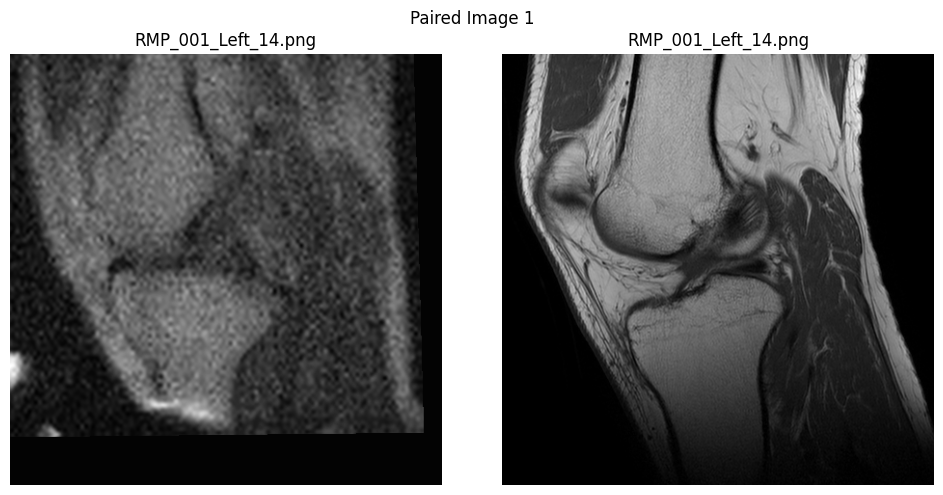

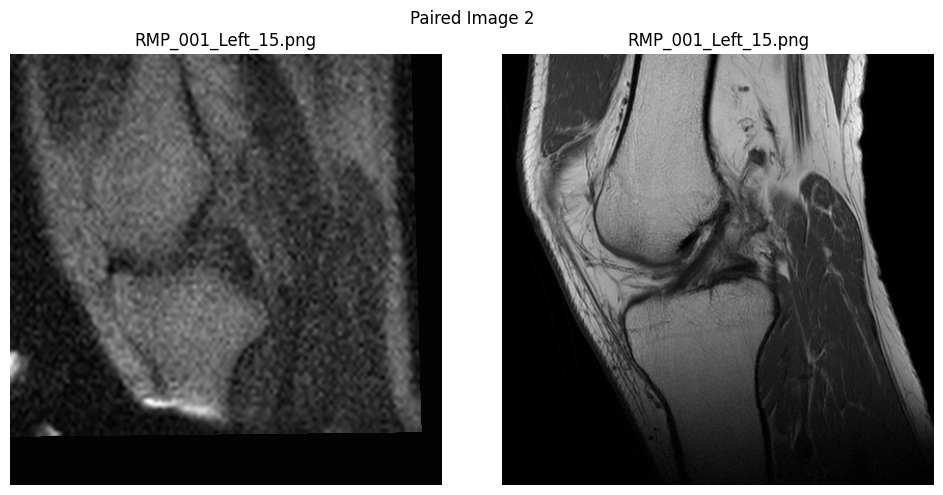

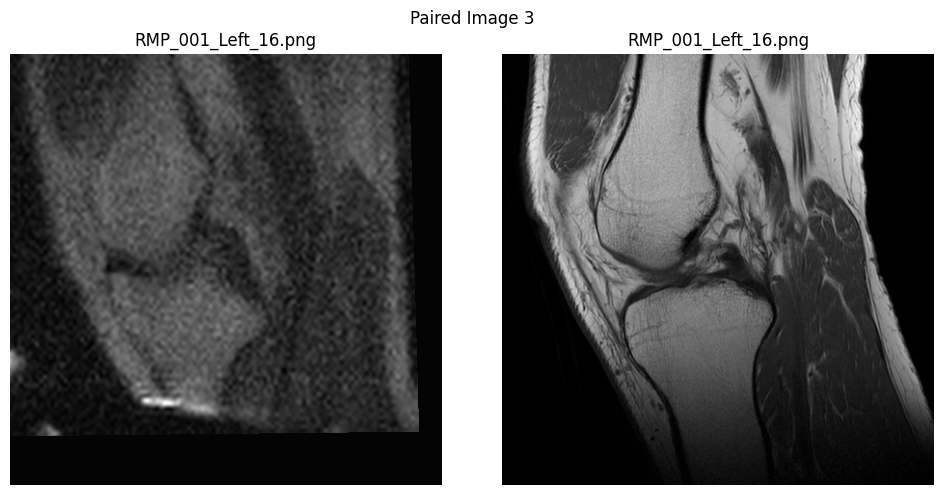

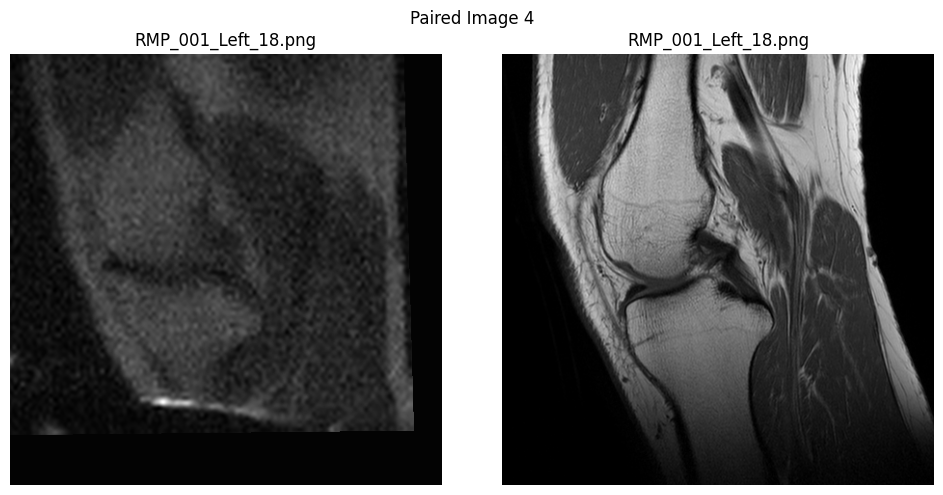

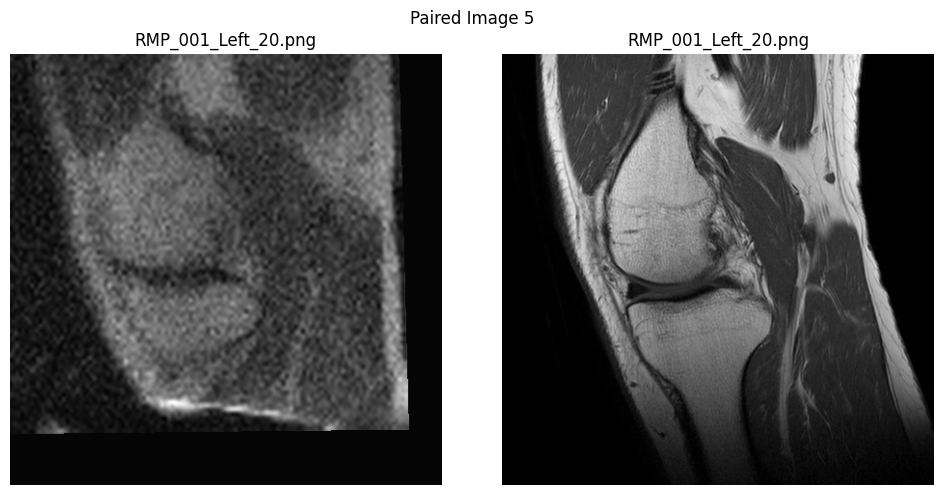

In [ ]:
def display_paired_images_with_filenames(high_field_dir, low_field_dir, num_pairs=5):
    """
    Displays pairs of images from high and low field directories with their filenames.

    Args:
        high_field_dir (str): Path to the directory containing high field images.
        low_field_dir (str): Path to the directory containing low field images.
        num_pairs (int): The number of image pairs to display (default is 5).
    """
    if not (os.path.isdir(high_field_dir) and os.path.isdir(low_field_dir)):
        raise Exception("Either High_field or Low_field directory is missing.")

    high_images = sorted([f for f in os.listdir(high_field_dir) if f.endswith('.png')])
    low_images = sorted([f for f in os.listdir(low_field_dir) if f.endswith('.png')])

    max_pairs = min(num_pairs, len(high_images), len(low_images))

    for i in range(max_pairs):
        high_img_path = os.path.join(high_field_dir, high_images[i])
        low_img_path = os.path.join(low_field_dir, low_images[i])

        try:
            with Image.open(high_img_path) as high_img, Image.open(low_img_path) as low_img:
                fig, axes = plt.subplots(1, 2, figsize=(10, 5))

                axes[0].imshow(low_img, cmap='gray')
                axes[0].set_title(low_images[i])
                axes[0].axis('off')

                axes[1].imshow(high_img, cmap='gray')
                axes[1].set_title(high_images[i])
                axes[1].axis('off')

                plt.suptitle(f"Paired Image {i + 1}")
                plt.tight_layout()
                plt.show()
        except FileNotFoundError:
            print(f"Could not find one of the image files for pair {i+1}. Skipping.")
        except Exception as e:
            print(f"An error occurred while processing pair {i+1}: {e}")

display_paired_images_with_filenames(train_high_field, train_low_field, num_pairs=5)

## Define albumentations transforms


In [ ]:
import albumentations as A

# Define a composition of Albumentations transforms
albumentations_transforms = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])

print("Albumentations transforms defined.")

Albumentations transforms defined.


## Update dataset for albumentations

Modify the `CustomImageDataset` to accept and apply Albumentations transforms.


In [ ]:
import os
import pandas as pd
from torchvision.io import decode_image
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_pil_image
import torch
import numpy as np
import albumentations as A

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_transform=None):
        """
        Args:
            root_dir (string): Directory with all the image folders for each class.
            transform (callable, optional): Optional transform to be applied on a sample.
            target_transform (callable, optional): Optional transform to be applied on a label.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_files = []
        self.labels = []

        # Assume subdirectories within root_dir are class labels
        for label_name in os.listdir(root_dir):
            label_dir = os.path.join(root_dir, label_name)
            if os.path.isdir(label_dir):
                # Filter for image files (e.g., .png, .jpg, .jpeg)
                for img_file in os.listdir(label_dir):
                    img_path = os.path.join(label_dir, img_file)
                    if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.image_files.append(img_path)
                        self.labels.append(label_name) # Use directory name as label

        # Optional: Map string labels to integers if needed
        self.label_map = {label: i for i, label in enumerate(sorted(list(set(self.labels))))}
        # Ensure image_files and labels are sorted to maintain consistency
        # This is important for pairing in some visualization scenarios, though not strictly needed for basic dataset access
        # sorted_pairs = sorted(zip(self.image_files, self.labels))
        # self.image_files, self.labels = zip(*sorted_pairs) if sorted_pairs else ([], [])


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = decode_image(img_path) # decode_image returns a Tensor (C, H, W)

        label_name = self.labels[idx]
        label = self.label_map[label_name] # Get integer label

        # Convert the image Tensor to a NumPy array (H, W, C) for Albumentations
        # Handle potential alpha channel (4 channels) or convert to 3 channels if needed by transforms
        if image.shape[0] == 4:
             image = image[:3, :, :] # Keep only the first 3 channels (RGB)
        image = image.permute(1, 2, 0).numpy() # Convert to H, W, C for Albumentations

        if self.transform:
            # Apply Albumentations transforms
            augmented = self.transform(image=image)
            image = augmented['image']

        # Convert the NumPy array back to a PyTorch Tensor (H, W, C from Albumentations)
        # Albumentations returns uint8 NumPy array by default. Convert to float and permute.
        image = torch.from_numpy(image).permute(2, 0, 1).float() # Convert to C, H, W and float
        image = image / 255.0 # Scale to [0, 1] if not already done by transforms

        if self.target_transform:
            label = self.target_transform(label)

        return image, label

## Visualize transformed data

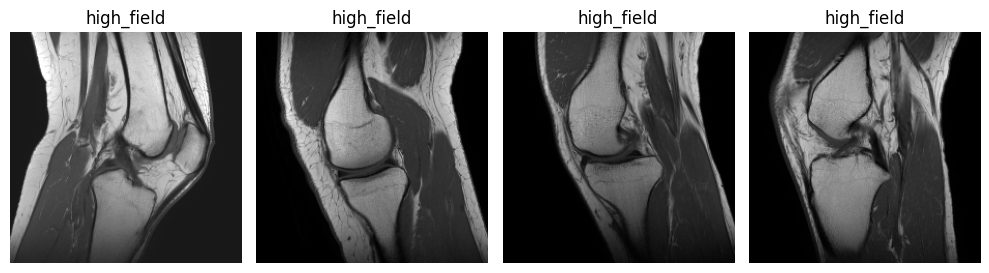

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Import numpy to handle image conversion

# Create an instance of the CustomImageDataset with Albumentations transforms
# Make sure albumentations_transforms is defined from a previous cell
# Use the correct root directory path
root_directory_path = '/content/drive/MyDrive/UgandanDataset/Data/train' # Your dataset root directory

transformed_dataset = CustomImageDataset(root_dir=root_directory_path, transform=albumentations_transforms)

# Define the number of images to display, ensuring it doesn't exceed dataset size
num_images_to_display = min(4, len(transformed_dataset))

if num_images_to_display == 0:
    print("No images found in the dataset to display.")
else:
    # Create a figure and subplots
    plt.figure(figsize=(10, 10))

    for i in range(num_images_to_display):
        # Get the image and label from the transformed dataset
        transformed_image, transformed_label_int = transformed_dataset[i]

        # Convert the PyTorch Tensor image to a format suitable for displaying with matplotlib
        # The image is a float Tensor (C, H, W). Convert to H, W, C NumPy array and scale to 0-255.
        # Assuming ToTensor() scaled to [0, 1] or Albumentations output is [0, 1], multiply by 255.
        # If your Albumentations output is uint8 [0, 255], no scaling is needed here.
        image_to_display = transformed_image.permute(1, 2, 0).numpy() # Convert C, H, W to H, W, C
        # Check if the image is already scaled to [0, 1] (float) or [0, 255] (uint8)
        # If it's float and max value is around 1, scale to 0-255
        if image_to_display.dtype == np.float32 and np.max(image_to_display) <= 1.0:
             image_to_display = (image_to_display * 255).astype(np.uint8)
        elif image_to_display.dtype == np.uint8:
             pass # Already in the correct format for display


        # Get the string label from the integer label using the label_map
        # Ensure the original_dataset (or any dataset instance with the label_map) is accessible
        # Access the label_map from the transformed_dataset instance
        label_string = list(transformed_dataset.label_map.keys())[list(transformed_dataset.label_map.values()).index(transformed_label_int)]


        # Display the image
        plt.subplot(1, num_images_to_display, i + 1)
        plt.imshow(image_to_display)
        plt.title(label_string)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Integrate with dataloader

Update the DataLoader to work with the dataset using Albumentations transforms if you plan to use it for training.


In [ ]:
from torch.utils.data import DataLoader

# Assuming you have already created the transformed_dataset from the previous step
# Define batch size
batch_size = 32 # You can adjust this based on your GPU memory and needs

# Create a DataLoader instance
# shuffle=True is typically used for the training dataset to randomize the order of samples
# Ensure transformed_dataset is defined in the previous cell and that cell has been run.
data_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)

print(f"DataLoader created with batch size: {batch_size}")
print(f"Number of batches per epoch: {len(data_loader)}")

# Access a single batch to verify the output shape (Optional)
try:
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    print("\nShape of a batch of images:", images.shape)
    print("Shape of a batch of labels:", labels.shape)

except NameError:
    print("Error: 'transformed_dataset' not found. Please make sure you have created the transformed dataset by running the previous cell.")
except StopIteration:
    print("DataLoader is empty or iteration finished.")
except Exception as e:
    print(f"An error occurred while accessing a batch: {e}")

DataLoader created with batch size: 32
Number of batches per epoch: 56

Shape of a batch of images: torch.Size([32, 3, 224, 224])
Shape of a batch of labels: torch.Size([32])


## Summary:

### Data Analysis Key Findings

*   The `albumentations` library was successfully installed (or confirmed as already installed).
*   Original images from the dataset were visualized, showing their initial appearance and corresponding labels before any transformations.
*   A sequence of Albumentations transforms was defined, including resizing to 224x224, horizontal flips, and random brightness/contrast adjustments.
*   The `CustomImageDataset` class was modified to correctly apply Albumentations transforms by converting images between PyTorch Tensor (C, H, W) and NumPy array (H, W, C) formats and handling potential 4-channel images.
*   Images were visualized after applying the defined Albumentations transforms, demonstrating the effect of the transformations on the dataset samples.
*   A PyTorch `DataLoader` was successfully created using the transformed dataset with a batch size of 32 and shuffling enabled, and the shape of a sample batch was verified.

### Insights or Next Steps

*   The dataset and DataLoader are now ready for use in training a deep learning model, incorporating data augmentation through Albumentations to potentially improve model robustness and performance.
*   Further experimentation could involve exploring different Albumentations transforms (e.g., rotations, shifts, color jitter) and adjusting their probabilities to find an optimal augmentation strategy for the specific image classification task.
